Данные для анализа взяты с сайта ChaLearn Looking at People из папки /datasets/faces/. В вашем распоряжении одна папка с изображениями (/final_files) и файл labels.csv с информацией о файле и реальном возрасте.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import os

1.1 Размер выборки

In [2]:
# Загрузка CSV-файла с информацией о файлах и возрасте
csv_file = '/datasets/faces/labels.csv'
data = pd.read_csv(csv_file)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
# Создание объекта ImageDataGenerator для извлечения данных
datagen = ImageDataGenerator(rescale=1./255)

# Использование flow_from_dataframe для извлечения данных из папки
image_dir = '/datasets/faces/final_files'
image_size = (150, 150)
batch_size = 32
generator = datagen.flow_from_dataframe(
    dataframe=data,
    directory=image_dir,
    x_col='file_name',
    y_col='real_age',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw'
)

Found 7591 validated image filenames.


In [6]:
image_shape = generator.image_shape
print("Размер загружаемых изображений: ", image_shape)

Размер загружаемых изображений:  (150, 150, 3)


1.2 Распределение возраста в выборке

Построим график, отображающий распределение возраста в выборке для лучшего понимания данных.

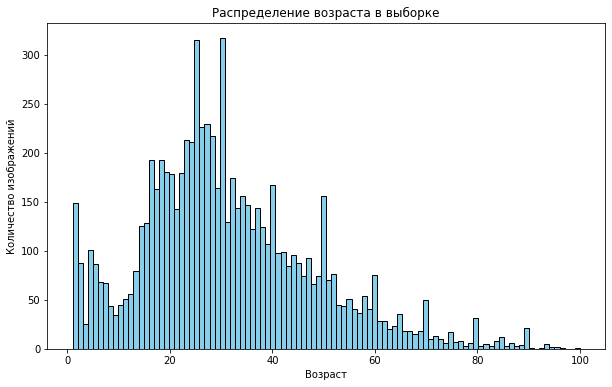

In [7]:
# Построение гистограммы распределения возраста
plt.figure(figsize=(10, 6))
plt.hist(data['real_age'], bins=100, color='skyblue', edgecolor='black')
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

1.3 Визуальный анализ данных

Выведем на экран 10–15 фотографий из датасета для более наглядного представления о данных.

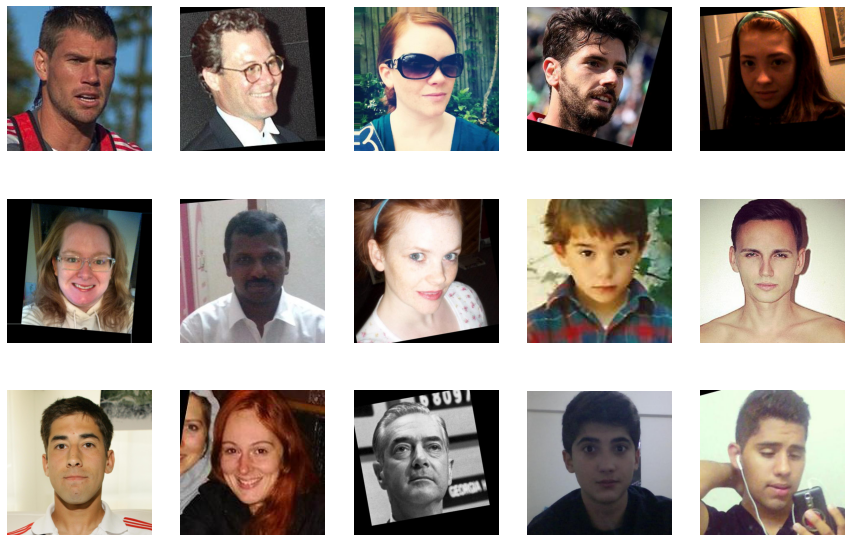

In [8]:
# Отображение 10–15 фотографий
image_folder = '/datasets/faces/final_files'
image_files = data['file_name'].sample(15).values

plt.figure(figsize=(15, 10))
for i, image in enumerate(image_files):
    plt.subplot(3, 5, i + 1)
    img = mpimg.imread(os.path.join(image_folder, image))
    plt.imshow(img)
    plt.axis('off')
plt.show()

Оценим качество данных:

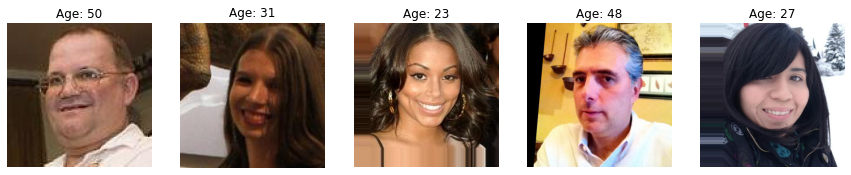

Средний возраст:  31.20115926755368
Стандартное отклонение возраста:  17.14393040879114
Минимальный возраст:  1
Максимальный возраст:  100


In [9]:
# Выведение случайного изображения из набора данных
def visualize_random_images(data, image_dir, num_images=5):
    fig, ax = plt.subplots(1, num_images, figsize=(15, 3))
    random_indices = np.random.choice(data.index, num_images, replace=False)
    for i, idx in enumerate(random_indices):
        img_path = os.path.join(image_dir, data.loc[idx, 'file_name'])
        img = plt.imread(img_path)
        ax[i].imshow(img)
        ax[i].set_title('Age: ' + str(data.loc[idx, 'real_age']))
        ax[i].axis('off')
    plt.show()

# Оценка разметки возраста
def evaluate_age_annotation(data):
    age_values = data['real_age'].values
    age_mean = np.mean(age_values)
    age_std = np.std(age_values)
    age_min = np.min(age_values)
    age_max = np.max(age_values)
    print("Средний возраст: ", age_mean)
    print("Стандартное отклонение возраста: ", age_std)
    print("Минимальный возраст: ", age_min)
    print("Максимальный возраст: ", age_max)

# Вызов функций для оценки данных
visualize_random_images(data, image_dir, num_images=5)
evaluate_age_annotation(data)

Выводы:

 У нас задача регрессии.
 
 Данные возрастов распределены не равномерно. Обратим внимание на равномерное представительство возрастных групп при обучении модели.
 
  Изображения цветные, значит будем использовать трёхмерный массив. 
  
  Фоны у фотографий разные. Значит могут быть полезными методы обработки изображений, например, обрезка или изменение фона, для улучшения обучения модели.
  
  Также изображения имеют разную яркость, но одинаковый размер (150, 150, 3).

 Функция для оценки разметки возраста успешно отработала. Средний возраст составляет примерно 31 год, с минимальным возрастом 1 год и максимальным возрастом 100 лет. Стандартное отклонение в 17.14 также демонстрирует разнообразие возрастных данных.
 Есть отклонения от разметки изображений.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# < 
import pandas as pd
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Функция подготовки тренировочных данных
def load_train(path, target_size=(224, 224), validation_split=.25, seed=12345):
    datagen = ImageDataGenerator(
        rotation_range = 40,
        width_shift_range = 30,
        height_shift_range = 30,
        zoom_range = [.8, .8],
        horizontal_flip = True, 
        rescale=1./255,
        validation_split=validation_split
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'), 
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age', 
        target_size=target_size,
        class_mode='raw',
        subset='training',
        seed=seed
    )

    return datagen_flow


# Функция подготовки тестовых данных
def load_test(path, target_size=(224, 224), validation_split=.25, seed=12345):
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv') ,
        directory=path + 'final_files/', 
        x_col='file_name',
        y_col='real_age', 
        target_size=target_size,
        class_mode='raw',
        subset='validation',
        seed=seed
    )

    return datagen_flow


# Функция создания модели нейросети
def create_model(input_shape, weights_path='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', learning_rate=.00003):
    backbone = ResNet50(input_shape=input_shape,
                        weights=weights_path,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer_adam = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer_adam, 
                  loss='mean_squared_error', 
                  metrics=['mean_absolute_error'])

    model.summary() 

    return model


# Функция обучения модели нейросети
def train_model(model, train_datagen_flow, test_datagen_flow, batch_size=None, epochs=9, steps_per_epoch=None, validation_steps=None):
    model.fit(train_datagen_flow, 
              validation_data=test_datagen_flow, 
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)

    return model >

```

```2024-06-04 15:50:27.203026: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2024-06-04 15:50:27.204682: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2024-06-04 15:50:28.070163: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-06-04 15:50:28.679437: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-06-04 15:50:28.679542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-04 15:50:28.679591: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-04 15:50:28.681691: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-06-04 15:50:28.682060: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-06-04 15:50:28.684029: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-06-04 15:50:28.685136: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-06-04 15:50:28.685190: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-06-04 15:50:28.688745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2024-06-04 15:50:28.858983: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-06-04 15:50:28.865172: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2024-06-04 15:50:28.865753: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5028620 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-06-04 15:50:28.865778: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-06-04 15:50:29.004249: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4688fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-04 15:50:29.004285: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-06-04 15:50:29.006374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2024-06-04 15:50:29.006452: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-04 15:50:29.006469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-04 15:50:29.006516: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-06-04 15:50:29.006534: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2024-06-04 15:50:29.006547: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2024-06-04 15:50:29.006557: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2024-06-04 15:50:29.006565: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2024-06-04 15:50:29.010040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2024-06-04 15:50:29.010112: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-06-04 15:50:29.340398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-06-04 15:50:29.340447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2024-06-04 15:50:29.340455: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2024-06-04 15:50:29.343555: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-06-04 15:50:29.343600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
=================================================================
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/9
2024-06-04 15:50:40.240580: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-04 15:50:40.694521: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 101s - loss: 523.5513 - mean_absolute_error: 17.4929 - val_loss: 387.6466 - val_mean_absolute_error: 14.7370
Epoch 2/9
178/178 - 90s - loss: 124.7081 - mean_absolute_error: 8.4017 - val_loss: 749.7201 - val_mean_absolute_error: 22.4542
Epoch 3/9
178/178 - 90s - loss: 97.8924 - mean_absolute_error: 7.4199 - val_loss: 566.7324 - val_mean_absolute_error: 18.7216
Epoch 4/9
178/178 - 90s - loss: 81.2046 - mean_absolute_error: 6.8529 - val_loss: 147.1322 - val_mean_absolute_error: 9.1808
Epoch 5/9
178/178 - 91s - loss: 72.6650 - mean_absolute_error: 6.4833 - val_loss: 99.0875 - val_mean_absolute_error: 7.4828
Epoch 6/9
178/178 - 91s - loss: 63.4874 - mean_absolute_error: 6.0821 - val_loss: 83.4598 - val_mean_absolute_error: 6.8347
Epoch 7/9
178/178 - 93s - loss: 55.5410 - mean_absolute_error: 5.7187 - val_loss: 78.7877 - val_mean_absolute_error: 6.6186
Epoch 8/9
178/178 - 92s - loss: 51.7798 - mean_absolute_error: 5.5038 - val_loss: 78.9816 - val_mean_absolute_error: 6.6896
Epoch 9/9
178/178 - 92s - loss: 47.7811 - mean_absolute_error: 5.2934 - val_loss: 96.5780 - val_mean_absolute_error: 7.4356
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 96.5780 - mean_absolute_error: 7.4356
Test MAE: 7.4356
# < >

```

## Анализ обученной модели

Цель модели достигнута. Результат меньше 8: Test MAE: 7.4356. Модель ошибается на 7.4356 лет.

Рекомендации по датасету и модели:

 В датасете все таки данные возрастов были даны не равномерно:
Фотографии людей в основном среднего возраста. Мало людей старшего и младшего возвраста.
В дальнейшем рекомендую собирать датасет с более равномерным наполнением.

Также можно поиграть еще с количеством слоев и количеством эпох для улучшения результата модели.

Рекомендации для использования модели:

Модель возможна для использования для возврастных рекомендаций и акционных предложений.

Не рекомендую использовать для проверки возраста покупателей при продаже алкогольной и табачной продукции.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы